# Commodity Food Pricing: Model Experiments

**By:** `MSOE AI-Club "Nourish" Student Research Team`<br/>
**Primary Notebook Developer:** Ben Paulson, ____

**Notebook Purpose:** To explore the use of machine learning to predict the price of commodities in the food industry. By utilizing the clean datasets loaded from `data_analysis.ipynb` into the directory `model_data`, we can begin to explore the use of machine learning to predict the price of commodities in the food industry. This notebook will be divided into sections of varying complexity, each of which will explore a different model type and its performance on the data. The models will be evaluated based on their ability to predict the price of a commodity in the future, given a set of features. The features will be selected based on their correlation to the price of the commodity, as determined in `data_analysis.ipynb`. There is also significant documentation with each section for both code/purpose sanity, sake of future reproducibility, and to help other members of the `MSOE AI-Club "Nourish" Student Research Team` understand the code and its purpose.
* **Part 1: Loading the Experiment(s) Data**
* **Part 2: Building Complex ML Models**
    * **Model 1:** Simple, 1-layer Transformer
    * **Model 2:** ...
* **Part 3: Experiments with Training Methods**
    * **Method 1:** ...
    * **Method 2:** ...

**Research Context:** This research is being conducted as part of the MSOE AI-Club's "Nourish" project, which aims to use machine learning to predict future food prices in order to help farmers in developing countries make better decisions about food storage and crop selection, achieved through the accurate warning administration and prediction of food commodity pricing data by country and food market. This project is pending as part of a relationship with the United Nation's Food and Agriculture Organization (FAO). [FAO Official Statement on the Importance of Research Like This](https://youtu.be/sZx3hhnEHiI)

In [1]:
# External Data Manipulation Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Machine Learning Packages
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Internal Python Packages
import os

## Part 1: Loading the Experiment(s) Data
Based on the data retrieved from `data_analysis.ipynb`, get that data into a format capable of being used by a Machine Learning model.

<span style="color: orange;">**Future Experiment:** Generating multiple months or simply estimating a year in advance.</span>

In [2]:
MODEL_DATA_DIRECTORY = 'model_data/wheat_model_data/'
N_TREND_SAMPLES = 3 # Number of price samples for "history" trend (training data)
MONTHS_AHEAD = 1 # Number of months ahead to predict
TEST_SIZE = 0.2
OUTPUT_COLUMN_NAME = 'Price'

# Get the number of features for this model (given the model_data chosen)
sample_file_path = os.path.join(MODEL_DATA_DIRECTORY, os.listdir(MODEL_DATA_DIRECTORY)[0])
sample_columns = pd.read_csv(sample_file_path).columns[1:] # Skip 'Unnamed: 0' column
num_input_samples = len(sample_columns[2:-1]) + N_TREND_SAMPLES + 1 # +1 for 'n_previous_prices' later
print("Num Features: ", num_input_samples)

Num Features:  9


In [3]:
def grab_n_previous_prices(model_data, n):
    """
    For the given model_data, grab the n previous prices and store as a list
    in a new column called 'n_previous_prices' for each row's associated 'Date'.
    The current date's price should not be included in the list of previous prices.
    :param pd.DataFrame model_data: data (model_data to grab from)
    :param int n: Number of previous prices to grab
    """
    # Create a new column to store the n_previous_prices
    model_data['n_previous_prices'] = None

    # Iterate through each row
    for index, row in model_data.iterrows():
        # Grab the date and price for the current row
        date = row['Date']
        price = row['Price']

        # Grab the n previous prices
        n_previous_prices = model_data.loc[model_data['Date'] < date]['Price'].tail(n).tolist()

        # Store the n_previous_prices in the new column
        model_data.at[index, 'n_previous_prices'] = n_previous_prices

    return model_data

In [4]:
def divide_inputs_and_outputs(row):
    """
    Create a column to specifically be input into an ML model and a column for output
    :param pd.DataFrame row: row to divide

    :return: row with input and output columns
    """
    output = row[OUTPUT_COLUMN_NAME]
    inputs = row[2:-1].tolist()

    # For each element in n_previous_price, add it to the inputs
    for price in row['n_previous_prices']:
        inputs.append(price)

    return pd.Series([inputs, output], index=['inputs', 'output'])

In [5]:
def format_for_ML_usage(inputs, outputs):
    """
    Given the inputs and outputs for the model, format the data to be used for ML.
    This is accomplished by splitting the data into training/test tensors
    :param inputs: inputs for the model (list of lists)
    :param output: output for the model (list of values)

    :return: The tensors responsible for testing/training the model and the scaler used to scale the data
            (x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler)
    """
    # Create a train/test split for the dataset
    x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=TEST_SIZE, shuffle=False)

    # Determine if there are any nan values in x_train
    for i in range(len(x_train)):
        if np.isnan(x_train[i]).any():
            print(f'x_train[{i}] has nan values! Check the data!')

    # Convert them all to numpy arrays
    x_train = np.array(x_train).reshape(-1, num_input_samples)
    x_test = np.array(x_test).reshape(-1, num_input_samples)
    y_train = np.array(y_train).reshape(-1, 1) # required reshape for StandardScaler
    y_test = np.array(y_test).reshape(-1, 1) # required reshape for StandardScaler

    # Standardize/Normalize the dataset
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train).reshape(-1, num_input_samples, 1)
    x_test_scaled = scaler.transform(x_test).reshape(-1, num_input_samples, 1)
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)

    # Convert to tensors for model ingestion (true training data)
    x_train_tensor = tf.convert_to_tensor(x_train_scaled)
    x_test_tensor = tf.convert_to_tensor(x_test_scaled)
    y_train_tensor = tf.convert_to_tensor(y_train_scaled)
    y_test_tensor = tf.convert_to_tensor(y_test_scaled)

    return (x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler)

In [6]:
def get_model_data_from_directory():
    """
    Based off the directory provided in the constant MODEL_DATA_DIRECTORY, grab the model_data

    :return: A finalized csv of the model data ready for numpy/tensor conversion
    """
    # Grab all the files in the directory
    model_data = pd.DataFrame(columns = sample_columns)
    for file in os.listdir(MODEL_DATA_DIRECTORY):
        data_to_concat = pd.read_csv(os.path.join(MODEL_DATA_DIRECTORY, file))
        
        # Sort model data where the earliest date comes first and the latest data comes last
        data_to_concat['Date'] = pd.to_datetime(data_to_concat['Date'])
        data_to_concat = data_to_concat.sort_values(by='Date')

        # Get the n previous prices
        data_to_concat = grab_n_previous_prices(data_to_concat, N_TREND_SAMPLES)

        # Remove the rows where the len(n_previous_prices) != N_TREND_SAMPLES
        data_to_concat = data_to_concat[data_to_concat['n_previous_prices'].apply(lambda x: len(x) == N_TREND_SAMPLES)]

        # The 'Sentiment' column contains some nan values when articles weren't published. Replace these with 0
        data_to_concat['Sentiment'] = data_to_concat['Sentiment'].fillna(0)

        # Concat all the data together
        model_data = pd.concat([model_data, data_to_concat], ignore_index=True).drop(columns=['Unnamed: 0'])

    return model_data

In [7]:
model_data = get_model_data_from_directory()
model_data

,Date,Price,Proteus2,Food Price Index,Cereals Price Index,Wheat Futures,Harvest,Sentiment,n_previous_prices
0,2003-02-01,-0.292109,-0.263735,-0.188107,-0.259960,-0.285230,-0.233887,1.0,"[-0.385938739389716, -0.4291559728228726, -0.3..."
1,2003-03-01,-0.262720,-0.167999,-0.250844,-0.304561,-0.345851,-0.246750,1.0,"[-0.4291559728228726, -0.3622069813224381, -0...."
2,2003-04-01,-0.312009,-0.063420,-0.266222,-0.312649,-0.386508,-0.260383,1.0,"[-0.3622069813224381, -0.292109312769545, -0.2..."
3,2003-05-01,-0.197569,0.036381,-0.244554,-0.267140,-0.333346,-0.272976,1.0,"[-0.292109312769545, -0.2627204772230894, -0.3..."
4,2003-06-01,-0.185853,0.138070,-0.272785,-0.287712,-0.415659,-0.285377,1.0,"[-0.2627204772230894, -0.3120085767078758, -0...."
...,...,...,...,...,...,...,...,...,...
882,2016-08-01,-0.303599,0.356484,0.176158,-0.082286,-0.332789,0.513699,1.0,"[-0.3662145671233195, -0.3086239294957822, -0...."
883,2016-09-01,-0.270940,0.312071,0.246187,-0.120957,-0.279536,0.512166,1.0,"[-0.3086239294957822, -0.3377520859687284, -0...."
884,2016-10-01,-0.212972,0.268074,0.279014,-0.072769,-0.223906,0.510656,1.0,"[-0.3377520859687284, -0.3035993232696823, -0...."
885,2016-11-01,-0.191350,0.221549,0.309898,-0.053090,-0.197935,0.509068,1.0,"[-0.3035993232696823, -0.2709395138531508, -0...."


In [8]:
inputs_and_outputs = model_data.apply(divide_inputs_and_outputs, axis=1)
inputs = inputs_and_outputs['inputs'].tolist(); outputs = inputs_and_outputs['output'].tolist()
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=TEST_SIZE, shuffle=False) # Don't shuffle, should be cohesive samples not seen
x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler = format_for_ML_usage(inputs, outputs)

print('x_train_tensor shape:', x_train_tensor.shape)
print('x_test_tensor shape:', x_test_tensor.shape)
print('y_train_tensor shape:', y_train_tensor.shape)
print('y_test_tensor shape:', y_test_tensor.shape)

x_train_tensor shape: (709, 9, 1)
x_test_tensor shape: (178, 9, 1)
y_train_tensor shape: (709, 1)
y_test_tensor shape: (178, 1)


## Part 2: Building Complex ML Models

In [9]:
# Define positional encoding function (another portion for data preprocessing)
def positional_encoding(length, depth):
    """ 
    Create positional encoding
    args:
        length: length of the sequence
        depth: depth of the model
    """
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / depth) for j in range(depth)]
        for pos in range(length)
    ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])
    return tf.cast(pos_enc, dtype=tf.float32)

### Model 1: Simple, 1-Layer Transformer

In [112]:
HEAD_SIZE = 64
NUM_HEADS = 16
FF_DIM = 16
LEARNING_RATE = 1

d_model = x_train_tensor.shape[-1] 
length = x_train_tensor.shape[1]  

In [113]:
def transformer(head_size, num_heads, ff_dim, dropout=0, num_transformers=10):
    """
    Building a simple transformer based off the original work compiled in
    the research paper "Attention Is All You Need" (https://arxiv.org/pdf/1706.03762.pdf)
    :param int head_size: Size of the attention heads
    :param int num_heads: Number of heads
    :param int ff_dim: Feed forward dimension
    :param float dropout: Dropout rate
    """
    
    # Input Layer
    inputs = tf.keras.layers.Input(shape=(num_input_samples, d_model)) # (None, 9, 1)

    # Add positional encoding to the input
    # The positional encoding is added to the input in order to give the model some information about the relative position of the words in the sequence
    # Not including the positional encoding is basically the same as randomizing the order of the data
    positional_inputs = inputs + positional_encoding(num_input_samples, d_model) # (None, 9, 1)
    
    # Multi-Head Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(positional_inputs) # (None, 9, 1)
     
    for i in range(num_transformers):
        x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x) # (None, 9, 1)
        x = tf.keras.layers.Dropout(dropout)(x) # (None, 9, 1)
        
        # Add & Norm
        res = x + positional_inputs # (None, 9, 1)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res) # (None, 9, 1)
        
        # Feed-Forward Network (Using Dense layers instead of Conv1D layers)
        x = tf.keras.layers.Dense(ff_dim, activation='relu')(x) # (None, 9, 16)
        x = tf.keras.layers.Dropout(dropout)(x) # (None, 9, 16)
        
        # Skip Connection     
        x = x + res # (None, 9, 16)

    # Global Average Pooling layer
    # The Global Average Pooling layer reduces the dimensionality/complexity of the data
    x = tf.keras.layers.GlobalAveragePooling1D()(x) # (None, 16)
    
    # Output Layer
    outputs = tf.keras.layers.Dense(1, activation='tanh')(x) # (None, 1)

    return inputs, outputs

In [114]:
inputs,outputs = transformer(HEAD_SIZE, NUM_HEADS, FF_DIM)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
# Huber loss
model.compile(optimizer='adam', loss='huber', metrics = ['mae']) # Huber loss is less sensitive to outliers

# Ensure all the weights are reset
tf.keras.backend.clear_session()

# Researching Best Loss Functions for Trendline Prediction
# - Mean Absolute Error (MAE) - Emphasizes that all errors are equally important
# - Mean Absolute Percentage Error (MAPE) - Emphasizes that all errors are equally important (percentage-wise; normalized)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 9, 1)]               0         []                            
                                                                                                  
 tf.__operators__.add (TFOp  (None, 9, 1)                 0         ['input_1[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 layer_normalization (Layer  (None, 9, 1)                 2         ['tf.__operators__.add[0][0]']
 Normalization)                                                                                   
                                                                                              

In [115]:
# # Example prediction provided by the model (without training)
# example_prediction = model.predict(x_test_tensor)
# example_prediction = scaler.inverse_transform(example_prediction)
# example_prediction = example_prediction.reshape(-1)
# example_prediction

## Part 3: Training the Model
This section is specifically for training the model built in the previous section. Some contants (`NUM_EPOCHS`, `BATCH_SIZE`) are provided and should be the only required parameters to adjust for this section of the experiment. 

A plot of the loss throughout the training process is provided for easy understanding about if the model is overfitting or underfitting. For a review of these concepts, see [this article](https://www.analyticsfordecisions.com/overfitting-and-underfitting/#:~:text=Overfitting%20happens%20when%20the%20model%20is%20too%20complex,poor%20performance%20on%20both%20training%20and%20test%20datasets.).

**How the Model Will Change:**
* **Decrease the Learning Rate:** A smaller learning rate, such as 0.01, 0.001, or even smaller, is more typical and may help the optimizer converge properly.

* **Learning Rate Schedulers:** Implement a learning rate scheduler that can adapt the learning rate during training based on the performance.

* **Gradient Clipping:** In conjunction with a proper learning rate, gradient clipping can prevent the gradients from becoming too large, which can help stabilize training.

* **Model Complexity:** Ensure your model has the appropriate complexity to capture the stock price movements. This could mean adding more layers or changing the types of layers.

* **Regularization:** Use regularization techniques like dropout or L2 regularization to prevent overfitting, which can sometimes manifest as poor test set performance.

* **Batch Normalization:** This can help in stabilizing the learning process by normalizing the input to layers within the network.

In [116]:
NUM_EPOCHS = 20
BATCH_SIZE = 3 # Fiscal Quarters

In [117]:
# Train the model on our training data (train tensors)
history = model.fit(
    x_train_tensor[:-1, :], y_train_tensor[:-1, :],
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/20
236/236 [==============================] - 18s 30ms/step - loss: 0.4948 - mae: 0.8522
Epoch 2/20
236/236 [==============================] - 8s 32ms/step - loss: 0.6829 - mae: 1.0740
Epoch 3/20
236/236 [==============================] - 8s 32ms/step - loss: 0.6829 - mae: 1.0740
Epoch 4/20
236/236 [==============================] - 7s 30ms/step - loss: 0.6829 - mae: 1.0740
Epoch 5/20
236/236 [==============================] - 8s 34ms/step - loss: 0.6829 - mae: 1.0740
Epoch 6/20
236/236 [==============================] - 9s 39ms/step - loss: 0.6829 - mae: 1.0740
Epoch 7/20
236/236 [==============================] - 10s 40ms/step - loss: 0.6829 - mae: 1.0740
Epoch 8/20
236/236 [==============================] - 9s 39ms/step - loss: 0.6829 - mae: 1.0740
Epoch 9/20
236/236 [==============================] - 9s 39ms/step - loss: 0.6829 - mae: 1.0740
Epoch 10/20
236/236 [==============================] - 10s 42ms/step - loss: 0.6829 - mae: 1.0740
Epoch 11/20
236/236 [===============

KeyboardInterrupt: 

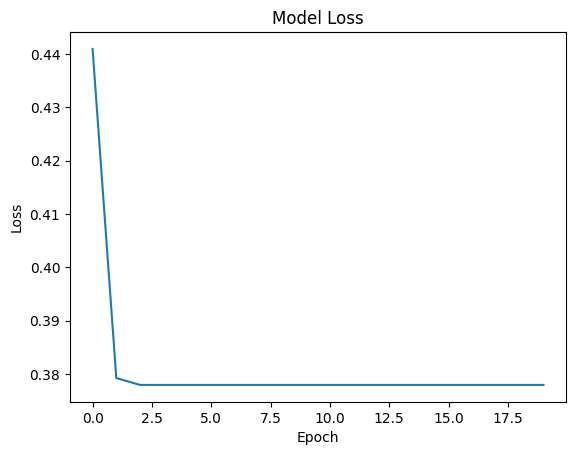

In [118]:
# Plot the loss over time
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Part 4: Examining Results
In this section, we're plotting the model's predictions versus the actual price point for the commodity in question. However, one plot focuses specifically on the testing data only (this is a better plot to see how well the model is performing/generalizing) and the other focuses on the entire dataset (this is a better plot to see if the model is correlating to the provided dataset at all).

Therefore, when **evaluating the performance** of the model, **the first plot should be used.** 

6/6 [==============================] - 2s 44ms/step


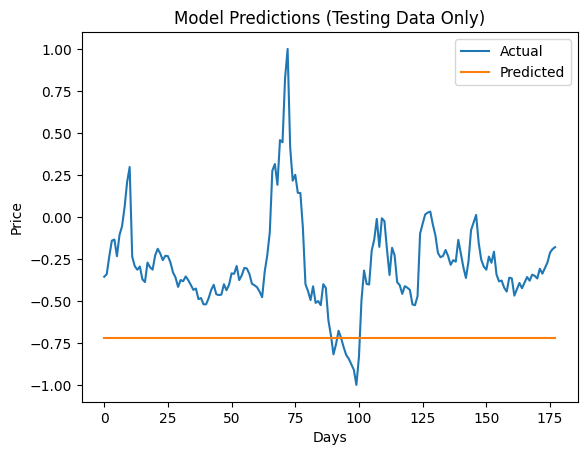

Mean Absolute Error (FINAL ACCURACY METRIC): 0.44426775124322426


In [119]:
# Plot the model's predictions of the testing data vs the actual data
predictions = model.predict(x_test_tensor)
predictions = scaler.inverse_transform(predictions)
predictions = predictions.reshape(-1)

plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Model Predictions (Testing Data Only)')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend()
plt.show()

# We use Mean Absolute Error (MAE) as the final accuracy metric because it is the true error (difference) between the actual and predicted values
print('Mean Absolute Error (FINAL ACCURACY METRIC):', mean_absolute_error(y_test, predictions))

23/23 [==============================] - 1s 27ms/step


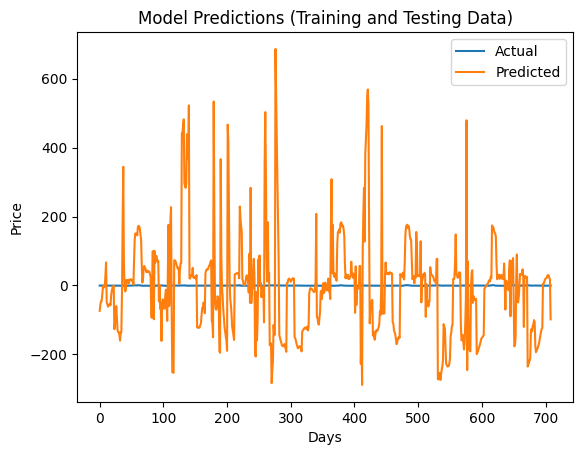

In [31]:
# Plot the model's predictions (both training and testing) vs the actual data
predictions = model.predict(x_train_tensor)
predictions = scaler.inverse_transform(predictions)
predictions = predictions.reshape(-1)

plt.plot(y_train, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Model Predictions (Training and Testing Data)')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend()
plt.show()